In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit
from collections import defaultdict

# Read data
d = pd.read_csv('newdata/RulevsMCTS_EloData2.csv')
max_games = 20000
d1 = d.copy()

def det_K(x, k1 = 40, k2 = 20, k3 = 10):
    if x <= 5:
        return k1
    elif x <= 10:
        return k2
    else:
        return k3

# Shuffle data
np.random.seed(1234)
d = d.sample(frac=1).reset_index(drop=True)

# Get unique strategies
users = pd.unique(d[['Strategy 1', 'Strategy 2']].values.ravel('K'))
ratings = dict.fromkeys(users, 1000)
games = dict.fromkeys(users, 0)

P1_rating = np.zeros(len(d))
P2_rating = np.zeros(len(d))

dynamic_ratings = pd.DataFrame(index=np.arange(max_games), columns=users)

for player in users:
    dynamic_ratings.loc[games[player], player] = ratings[player]

for i in range(len(d)):
    flag = 0
    s1 = d.loc[i, 'Strategy 1']
    s2 = d.loc[i, 'Strategy 2']

    games[s1] += 1
    games[s2] += 1

    K1 = det_K(games[s1])
    K2 = det_K(games[s2])

    A1 = 1-d.loc[i, 'Winner_ID']
    A2 = 1-A1
    D = ratings[s1] - ratings[s2]
    score_multiplier = abs(d.loc[i, 'P1 Score'] - d.loc[i, 'P2 Score'])/30
    I = d.loc[i, 'init.score1'] - d.loc[i, 'init.score2']

    E1 = 1 / (1 + 10**(-(D/400 - I/30)))
    E2 = 1 - E1

    ratings[s1] += round(K1 * score_multiplier *(A1 - E1))
    ratings[s2] += round(K2 * score_multiplier *(A2 - E2))

    if games[s1] < max_games:
        dynamic_ratings.loc[games[s1], s1] = ratings[s1]
    if games[s2] < max_games:
        dynamic_ratings.loc[games[s2], s2] = ratings[s2]

    P1_rating[i] = ratings[s1]
    P2_rating[i] = ratings[s2]

d['P1_rating'] = P1_rating
d['P2_rating'] = P2_rating

dynamic_ratings.index.name = 'Games'
dynamic_ratings = dynamic_ratings.astype('float')

In [25]:
ratings

{'Mindist + Opp': 1167, 'mcts-50': 984, 'mcts-25': 930, 'mcts-10': 886}

In [26]:
dynamic_ratings.head()

,Mindist + Opp,mcts-50,mcts-25,mcts-10
Games,,,,
0,1000.0,1000.0,1000.0,1000.0
1,1024.0,959.0,981.0,976.0
2,1027.0,961.0,967.0,973.0
3,1068.0,950.0,963.0,969.0
4,1087.0,909.0,961.0,978.0


In [27]:
# Moving average
window = 3000
df_long = dynamic_ratings.reset_index().melt(id_vars='Games', var_name='Series', value_name='Value')
df_long['Moving_Avg'] = df_long.groupby('Series')['Value'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean()
)
# df_long.head() df_long.tail()

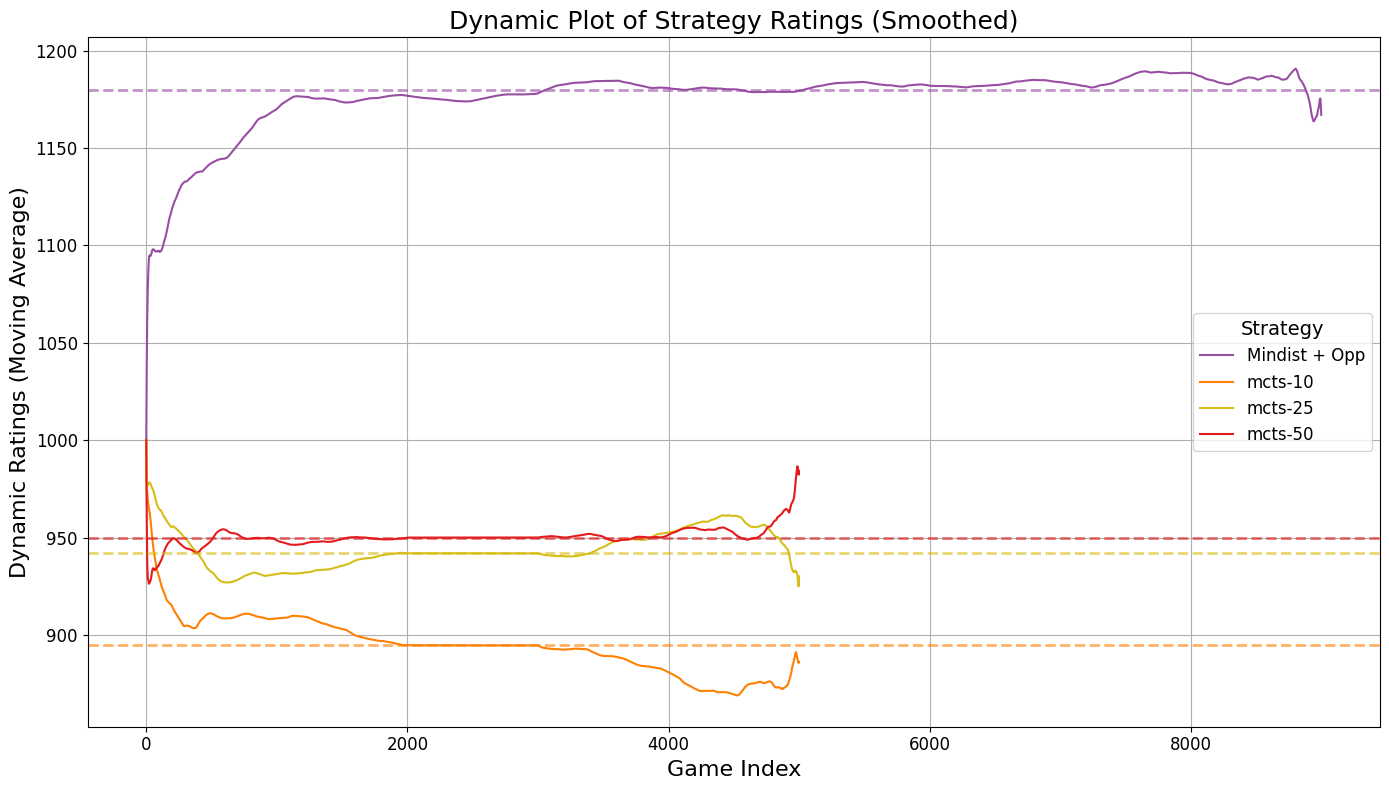

In [29]:
# Average lines
avg_lines = df_long.groupby('Series')['Value'].mean().reset_index()
avg_lines.columns = ['Series', 'Average']

# Plot
plt.figure(figsize=(14, 8))
main_colors = {
    "Mindist": "#e41a1c",
    "Random": "#377eb8",
    "Minscore": "#4daf4a",
    "Mindist + Opp": "#984ea3",
    "Mindist + minscore": "#ff7f00",
    "Defeat Heuristic": "#d7bd17",
    "mcts-0": "#377eb8",
    "mcts-50": "#e41a1c",
    "mcts-25": "#d7bd17",
    "mcts-10": "#ff7f00",
}
for name, group in df_long.groupby('Series'):
    if name in main_colors:
        plt.plot(group['Games'], group['Moving_Avg'], label=name, color=main_colors[name], linewidth=1.5)

for _, row in avg_lines.iterrows():
    if row['Series'] in main_colors:
        plt.axhline(y=row['Average'], color=main_colors[row['Series']], linestyle='--', alpha=0.6, linewidth=2)

plt.title('Dynamic Plot of Strategy Ratings (Smoothed)', fontsize=18)
plt.xlabel('Game Index', fontsize=16)
plt.ylabel('Dynamic Ratings (Moving Average)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Strategy', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()